In [1]:
import torch
from get_data_fs import *
from NN_classes_fs import *
from dataloader_fs import *
import os 
from tqdm import tqdm
import logging
from test_func_fs import *

torch.set_default_dtype(torch.float64)
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [ ]:
p1 = r"C:\Users\strasserp\Documents\ventil_lstm\data_fs\training_data_full_system_01_IV_sprung.csv"
p2 = r"C:\Users\strasserp\Documents\ventil_lstm\data_fs\training_data_full_system_01_IV2.csv"
p3 = r"C:\Users\strasserp\Documents\ventil_lstm\data_fs\training_data_full_system_01_same_u_und_mixed150.csv"

data = get_data(path=p3, num_inits=100)
# % matplotlib qt
for i in range(10):
    visualise(data, 50+i)

In [2]:
# train function

def train_tcn(input_data, model,  optimizer, lr_scheduler, learning_rate=0.001):
 
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
 
    model.train()
    total_loss = []
  
    for k, (x,y) in enumerate(input_data):  # inp = (u, x) label = x
        
        x = x.to(device)
        y = y.to(device)

        x = x.transpose(1,2)
        y = y.transpose(1,2)

        out = model(x)
  
        # reset the gradient
        optimizer.zero_grad(set_to_none=True)
        
        # calculate the error
        loss = loss_fn(out, y)
        loss.backward()
        optimizer.step()
 
        total_loss.append(loss.detach().cpu().numpy())

    lr_scheduler.step()
 
   # return the average error of the next step prediction
    return np.mean(total_loss)

def train_lstm(input_data, model,  optimizer, lr_scheduler, learning_rate=0.001):
 
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
 
    model.train()
    total_loss = []
  
    for k, (x,y) in enumerate(input_data):  # inp = (u, x) label = x
        
        x = x.to(device)
        y = y.to(device)
        
        output, _ = model(x)
  
        # reset the gradient
        optimizer.zero_grad(set_to_none=True)
        
        # calculate the error
        loss = loss_fn(output, y)
        loss.backward()
        optimizer.step()
        total_loss.append(loss.detach().cpu().numpy())
        lr_scheduler.step()

    return np.mean(total_loss)

def train_mlp(loader, model,  optimizer, lr_scheduler, learning_rate=0.001):
 
    loss_fn = nn.MSELoss()

 
    model.train()
    total_loss = []
  
    for x,y in loader:  # inp = (u, x) label = x
        
        x = x.to(device)
        y = y.to(device)
 
        out = model(x)
 
        #print(output.size())
        # reset the gradient
        optimizer.zero_grad(set_to_none=True)
        
        # calculate the error
        loss = loss_fn(out, y)
        loss.backward()
        optimizer.step()
        total_loss.append(loss.detach().cpu().numpy())
         
    # before_lr = optimizer.param_groups[0]["lr"]
    lr_scheduler.step()
    # after_lr = optimizer.param_groups[0]["lr"]
    # print("SGD lr %.4f -> %.4f" % (before_lr, after_lr))
    

   # return the average error of the next step prediction
    return np.mean(total_loss)

In [ ]:
### mlp ###
params_mlp =    {
                        "window_size" : 20,
                        "h_size" : 24,
                        "l_num" : 3,
                        "learning_rate" : 0.001,
                        "batch_size" : 3,
                        "act_fn" : "relu",
                        "nonlin_at_out" : None, #None if no nonlinearity at the end

                        "percentage_of_data" : 0.9,
                        "cut_off_timesteps" : 0,
                        "part_of_data" : 1,
                        "epochs" : 100,
                        "test_every_epochs" : 3,
                        "input_channels" : 5,
                        "output" : 3
                    }

# Configure logging
log_file = 'training_fullsystem.log'
filemode = 'a' if os.path.exists(log_file) else 'w'
logging.basicConfig(filename=log_file, filemode=filemode, level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Initialize the mlp model
model_mlp = OR_MLP(input_size=5*params_mlp["window_size"], hidden_size=params_mlp["h_size"], l_num=params_mlp["l_num"], output_size=3,
                    act_fn=params_mlp["act_fn"], act_at_end = None, timesteps=params_mlp["window_size"]).to(device)

# Generate input data (the data is normalized and some timesteps are cut off)
input_data1 = get_data(path = r"C:\Users\strasserp\Documents\ventil_lstm\data_fs\training_data_full_system_01_IV_sprung.csv", num_inits=params_mlp["part_of_data"])
input_data2 = get_data(path = r"C:\Users\strasserp\Documents\ventil_lstm\data_fs\training_data_full_system_01_IV2.csv", num_inits=params_mlp["part_of_data"])
input_data3 = get_data(path = r"C:\Users\strasserp\Documents\ventil_lstm\data_fs\training_data_full_system_01_randomwalk.csv", num_inits=params_mlp["part_of_data"])

input_data = torch.cat((input_data1, input_data2, input_data3))
print(input_data.size())

#Split data into train and test sets
np.random.seed(1234)
num_of_inits_train = int(len(input_data)*params_mlp["percentage_of_data"])
train_inits = np.random.choice(np.arange(len(input_data)),num_of_inits_train,replace=False)
test_inits = np.array([x for x in range(len(input_data)) if x not in train_inits])
np.random.shuffle(train_inits)
np.random.shuffle(test_inits)
train_data = input_data[train_inits,:input_data.size(dim=1)-params_mlp["cut_off_timesteps"],:]
test_data = input_data[test_inits,:,:]

# dataloader for batching during training
train_set_mlp = custom_simple_dataset(train_data, window_size=params_mlp["window_size"])
train_loader_mlp = DataLoader(train_set_mlp, batch_size=params_mlp["batch_size"], pin_memory=True)

average_traj_err_train_mlp=[]
#Training loop

optimizer = torch.optim.AdamW(model_mlp.parameters(), lr = params_mlp["learning_rate"])
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = 10, eta_min=0, last_epoch=-1, verbose='deprecated')

for e in tqdm(range(params_mlp["epochs"])):
    
    train_error = train_mlp(train_loader_mlp, model_mlp, optimizer=optimizer, lr_scheduler=lr_scheduler, learning_rate=params_mlp["learning_rate"])
    if e:
        print("Training error : ", train_error)

    # Every few epochs get the error MSE of the true data
    # compared to the network prediction starting from some initial conditions
    if (e+1)%params_mlp["test_every_epochs"] == 0:
        err_test_mlp = test(test_data.to(device), model_mlp, model_type="mlp", window_size=params_mlp["window_size"], display_plots=False, numb_of_inits = 1)
        average_traj_err_train_mlp.append(err_test_mlp)
        print(f"Average error over full trajectories: training data mlp: {err_test_mlp}")
        
# Save trained model
path_mlp = f'or_test_mlp.pth'

torch.save(model_mlp.state_dict(), path_mlp)

print(f"Run finished!")

# Log parameters

logging.info(f"hyperparams mlp: {params_mlp}")
logging.info(f"mlp {average_traj_err_train_mlp}")   
logging.info("--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------")
logging.info("\n")



In [ ]:
### LSTM ###
params_lstm =    {
                        "window_size" : 16,
                        "h_size" : 8,
                        "l_num" : 3,
                        "learning_rate" : 0.0008,
                        "batch_size" : 20,
                        "percentage_of_data" : 0.9,
                        "cut_off_timesteps" : 300,
                        "part_of_data" : 100,
                        "epochs" : 100,
                        "test_every_epochs" : 20,
                        "input_channels" : 5,
                        "output" : 3
                    }

# Configure logging
log_file = 'training_fullsystem.log'
filemode = 'a' if os.path.exists(log_file) else 'w'
logging.basicConfig(filename=log_file, filemode=filemode, level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Initialize the LSTM model
model_lstm = OR_LSTM(input_size=5, hidden_size=params_lstm["h_size"], out_size=3, layers=params_lstm["l_num"], window_size=params_lstm["window_size"]).to(device)

# Generate input data (the data is normalized and some timesteps are cut off)
input_data1 = get_data(path = r"C:\Users\strasserp\Documents\ventil_lstm\data_fs\training_data_full_system_01_IV_sprung.csv", num_inits=params_lstm["part_of_data"])
input_data2 = get_data(path = r"C:\Users\strasserp\Documents\ventil_lstm\data_fs\training_data_full_system_01_IV2.csv", num_inits=params_lstm["part_of_data"])
input_data3 = get_data(path = r"C:\Users\strasserp\Documents\ventil_lstm\data_fs\training_data_full_system_01_randomwalk.csv", num_inits=params_lstm["part_of_data"])

input_data = torch.cat((input_data1, input_data2, input_data3))
print(input_data.size())

#Split data into train and test sets
np.random.seed(1234)
num_of_inits_train = int(len(input_data)*params_lstm["percentage_of_data"])
train_inits = np.random.choice(np.arange(len(input_data)),num_of_inits_train,replace=False)
test_inits = np.array([x for x in range(len(input_data)) if x not in train_inits])
np.random.shuffle(train_inits)
np.random.shuffle(test_inits)
train_data = input_data[train_inits,:input_data.size(dim=1)-params_lstm["cut_off_timesteps"],:]
test_data = input_data[test_inits,:,:]

# dataloader for batching during training
train_set_lstm = custom_simple_dataset(train_data, window_size=params_lstm["window_size"])
train_loader_lstm = DataLoader(train_set_lstm, batch_size=params_lstm["batch_size"], pin_memory=True)

average_traj_err_train_lstm=[]
#Training loop
for e in tqdm(range(params_lstm["epochs"])):
    
    train_error = train_lstm(train_loader_lstm, model_lstm, learning_rate= params_lstm["learning_rate"])
    if e % 10:
        print("Training error : ", train_error)

    # Every few epochs get the error MSE of the true data
    # compared to the network prediction starting from some initial conditions
    if (e+1)%params_lstm["test_every_epochs"] == 0:
        err_test_lstm = test(test_data.to(device), model_lstm, model_type="lstm", window_size=params_lstm["window_size"], display_plots=False, numb_of_inits = 1)
        average_traj_err_train_lstm.append(err_test_lstm)
        print(f"Average error over full trajectories: training data LSTM: {err_test_lstm}")
        
# Save trained model
path_lstm = f'Full_System/or_test_lstm.pth'

torch.save(model_lstm.state_dict(), path_lstm)

print(f"Run finished!")

# Log parameters

logging.info(f"hyperparams LSTM: {params_lstm}")
logging.info(f"LSTM {average_traj_err_train_lstm}")   
logging.info("--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------")
logging.info("\n")

In [ ]:
# main (set parameters, logging, save model) 

params_tcn =    {
                        "window_size" : 30,
                        "learning_rate" : 0.001,
                        "batch_size" : 20,
                        "percentage_of_data" : 0.9,
                        "cut_off_timesteps" : 300,
                        "part_of_data" : 10,
                        "epochs" : 100,
                        "test_every_epochs" : 2,

                        "kernel_size" : 7,
                        "dropout" : 0,
                        "n_hidden" : 5,
                        "levels" : 4,
                        "input_channels" : 5,
                        "output" : 3
                    }

# Configure logging
log_file = 'training_fullsystem.log'
filemode = 'a' if os.path.exists(log_file) else 'w'
logging.basicConfig(filename=log_file, filemode=filemode, level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Initialize the TCN model
input_channels = params_tcn["input_channels"]
output = params_tcn["output"]
num_channels = [params_tcn["n_hidden"]] * params_tcn["levels"]
kernel_size = params_tcn["kernel_size"]
dropout = params_tcn["dropout"]
model_tcn = OR_TCN(input_channels, output, num_channels, kernel_size=kernel_size, dropout=dropout, windowsize=params_tcn["window_size"]).to(device)

# Generate input data (the data is normalized and some timesteps are cut off)
input_data1 = get_data(path = r"C:\Users\strasserp\Documents\ventil_lstm\data_fs\training_data_full_system_100.csv", num_inits=params_tcn["part_of_data"])
input_data2 = get_data(path = r"C:\Users\strasserp\Documents\ventil_lstm\data_fs\training_data_full_system_randomwalks.csv", num_inits=params_tcn["part_of_data"])

input_data = torch.cat((input_data1, input_data2))
print(input_data.size())

#Split data into train and test sets
np.random.seed(1234)
num_of_inits_train = int(len(input_data)*params_tcn["percentage_of_data"])
train_inits = np.random.choice(np.arange(len(input_data)),num_of_inits_train,replace=False)
test_inits = np.array([x for x in range(len(input_data)) if x not in train_inits])
np.random.shuffle(train_inits)
np.random.shuffle(test_inits)
train_data = input_data[train_inits,:input_data.size(dim=1)-params_tcn["cut_off_timesteps"],:]
test_data = input_data[test_inits,:,:]

# dataloader for batching during training
train_set_tcn = custom_simple_dataset(train_data, window_size=params_tcn["window_size"])
train_loader_tcn = DataLoader(train_set_tcn, batch_size=params_tcn["batch_size"], pin_memory=True)

average_traj_err_train_tcn = []

#Training loop
for e in tqdm(range(params_tcn["epochs"])):
    
    train_error = train_tcn(train_loader_tcn, model_tcn, learning_rate= params_tcn["learning_rate"])
    if e % 10:
        print("Training error : ", train_error)

    # Every few epochs get the error MSE of the true data
    # compared to the network prediction starting from some initial conditions
    if (e+1)%params_tcn["test_every_epochs"] == 0:
        err_test_tcn = test(test_data.to(device), model_tcn, model_type="tcn", window_size=params_tcn["window_size"], display_plots=True, numb_of_inits = 1)
        average_traj_err_train_tcn.append(err_test_tcn)
        print(f"Average error over full trajectories: training data TCN: {err_test_tcn}")
        
# Save trained model
path_tcn = f'Full_System/or_test_tcn.pth'

torch.save(model_tcn.state_dict(), path_tcn)

print(f"Run finished!")

# Log parameters

logging.info(f"hyperparams tcn: {params_tcn}")
logging.info(f"TCN {average_traj_err_train_tcn}")   
logging.info("--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------")
logging.info("\n")


torch.Size([300, 494, 5])


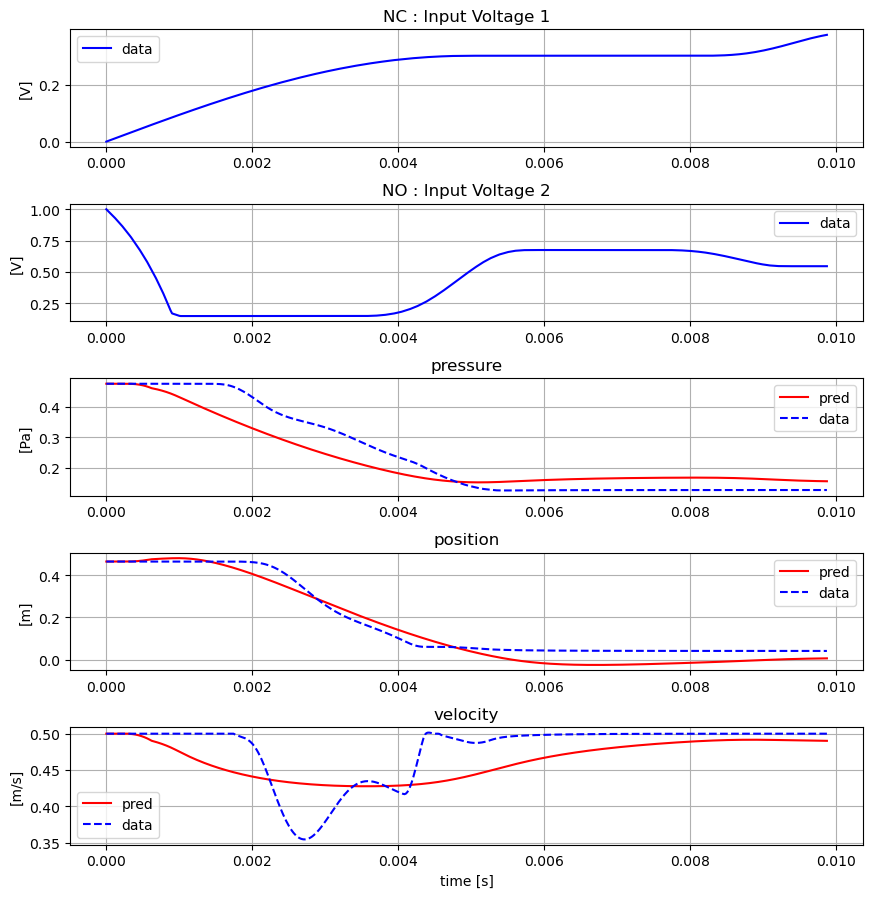

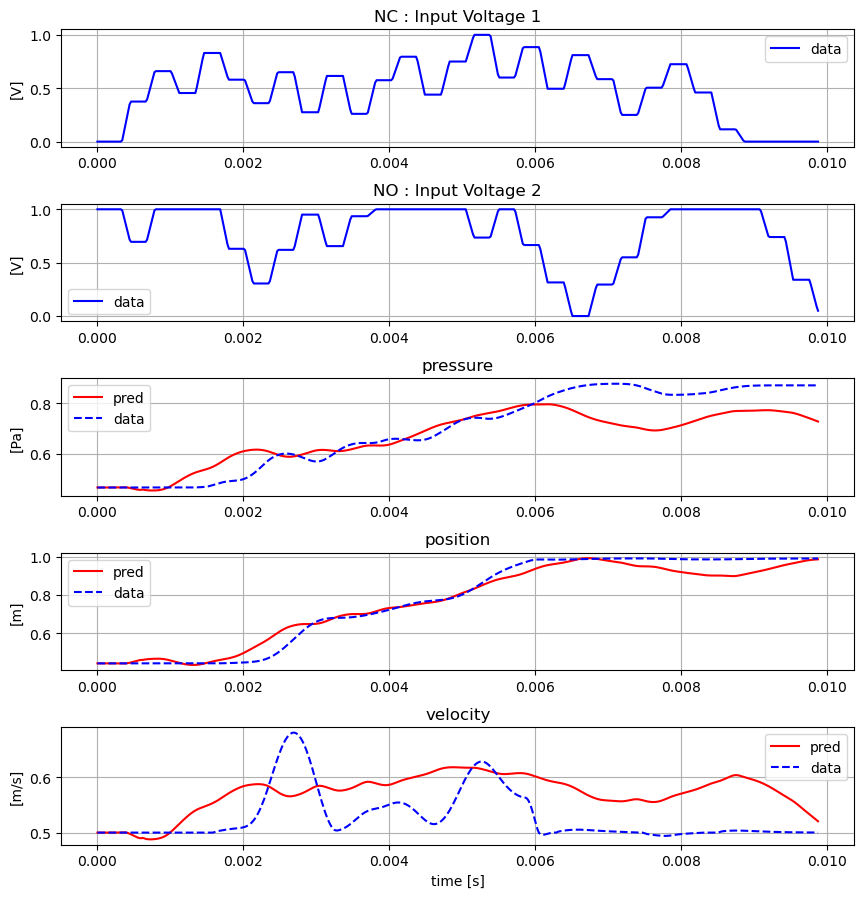

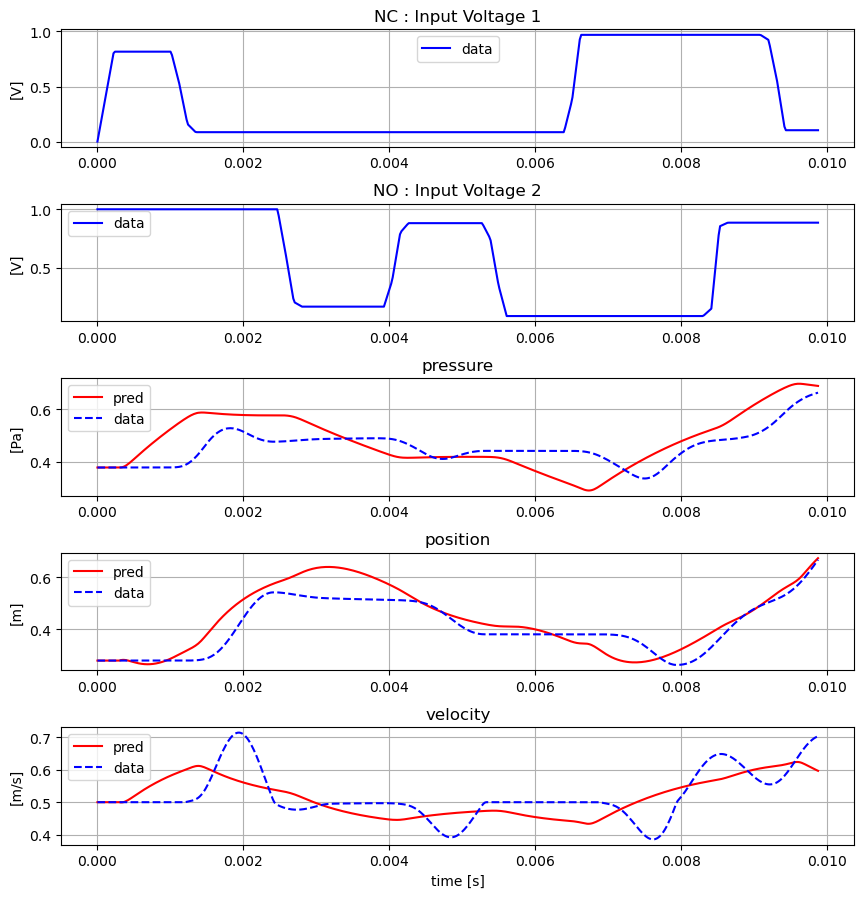

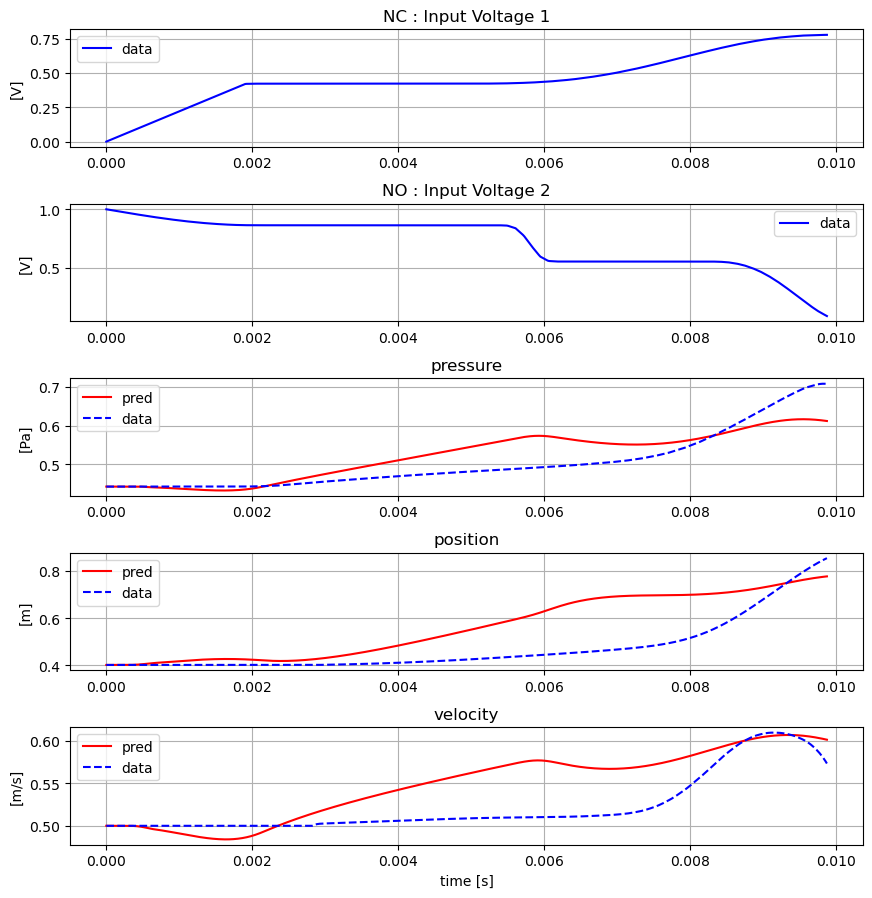

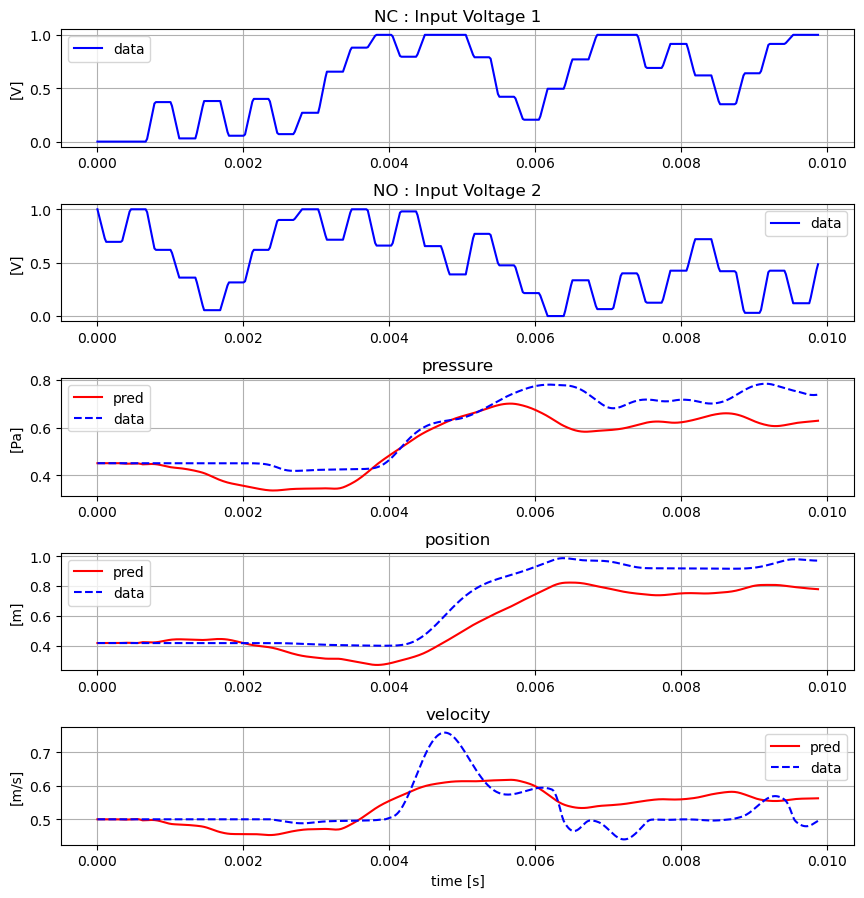

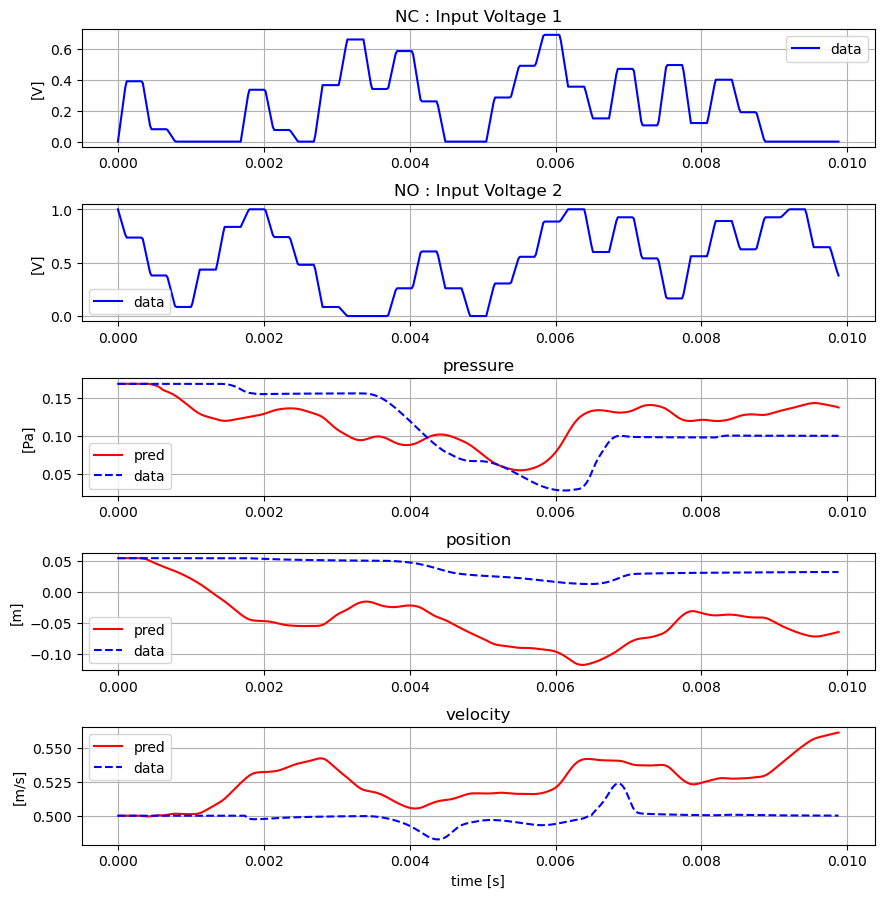

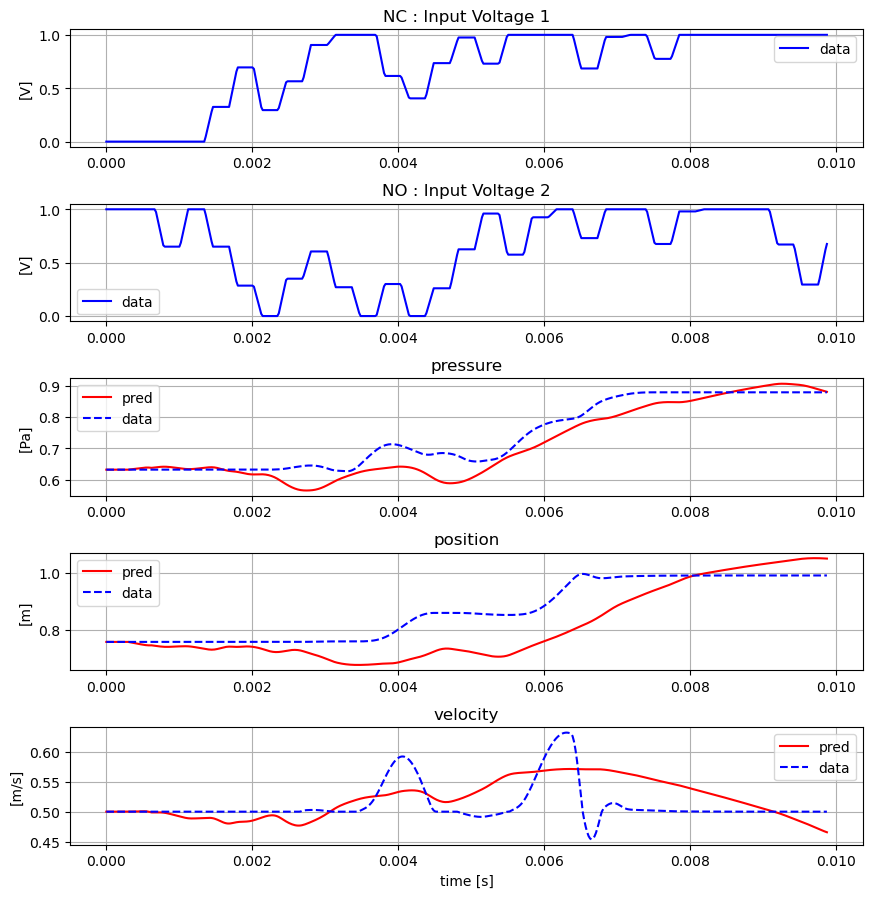

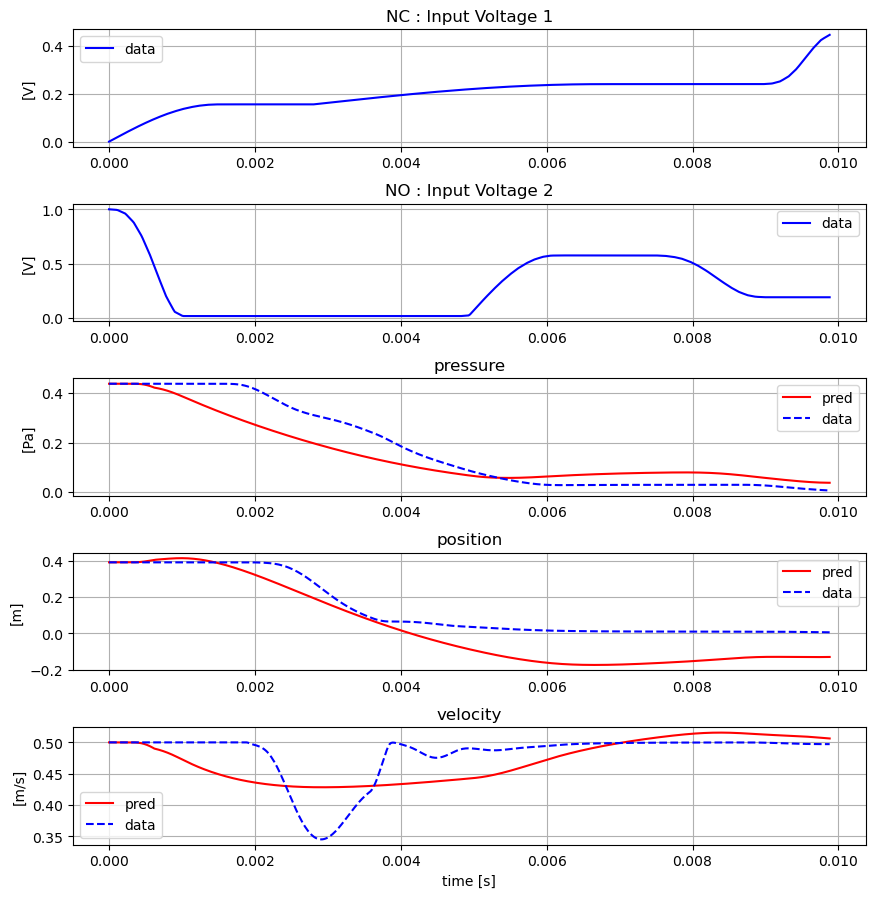

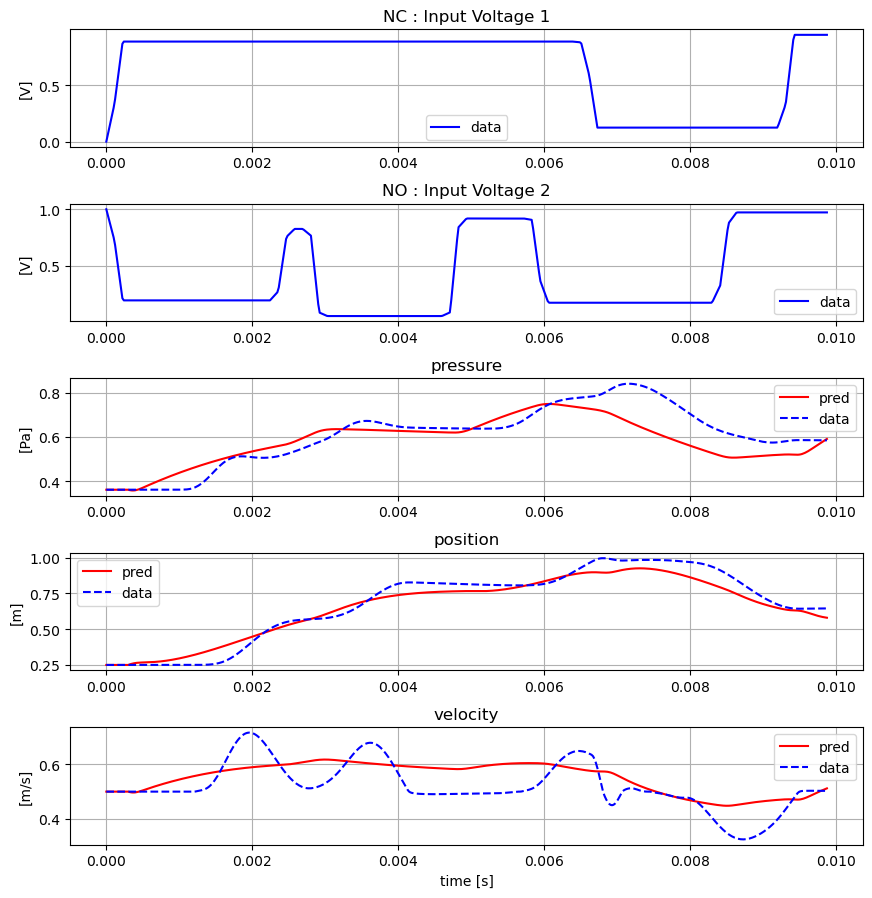

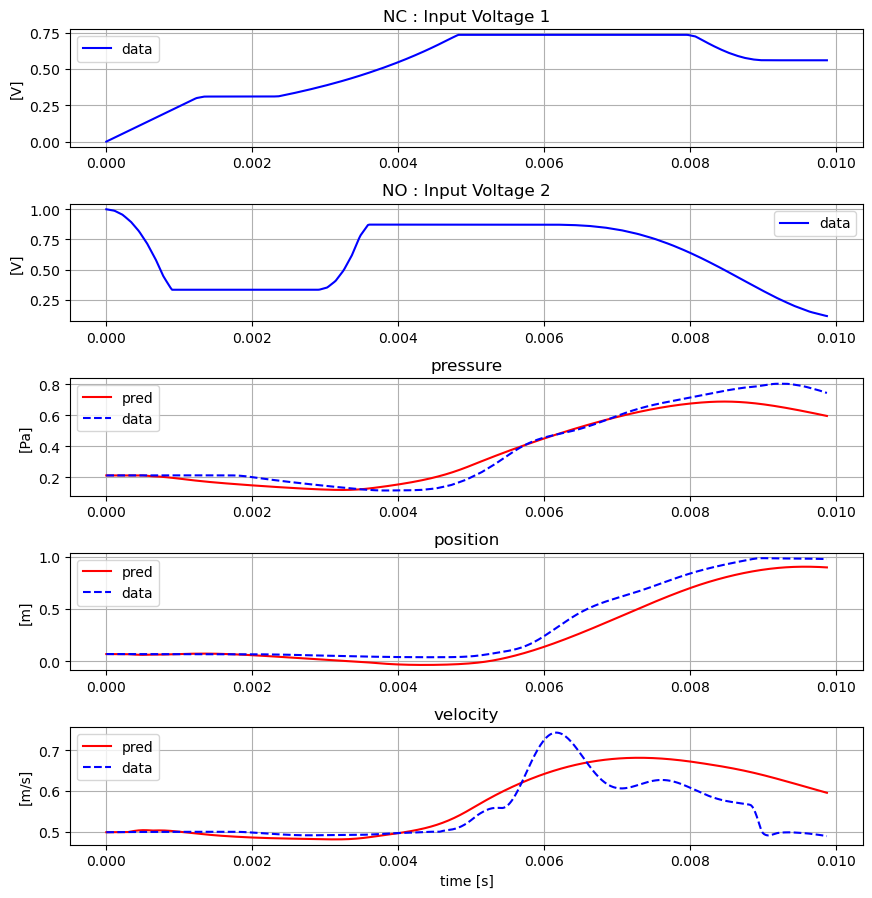

0.0056160276232051776

In [9]:

#main (set parameters, logging, save model) 

params_tcn =    {
                        "window_size" : 30,
                        "learning_rate" : 0.001,
                        "batch_size" : 20,
                        "percentage_of_data" : 0.9,
                        "cut_off_timesteps" : 300,
                        "part_of_data" : 0,
                        "epochs" : 100,
                        "test_every_epochs" : 2,

                        "kernel_size" : 7,
                        "dropout" : 0,
                        "n_hidden" : 5,
                        "levels" : 4,
                        "input_channels" : 5,
                        "output" : 3
                    }

params_lstm =    {
                        "window_size" : 16,
                        "h_size" : 8,
                        "l_num" : 3,
                        "learning_rate" : 0.001,
                        "batch_size" : 20,

                        "percentage_of_data" : 0.9,
                        "cut_off_timesteps" : 0,
                        "part_of_data" : 0,
                        "epochs" : 1000,
                        "test_every_epochs" : 100,

                        "T_max" : 500,

                        "experiment_number" : np.random.randint(0,1000)
                        }


# Configure logging
log_file = 'training_fullsystem.log'
filemode = 'a' if os.path.exists(log_file) else 'w'
logging.basicConfig(filename=log_file, filemode=filemode, level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Initialize the TCN model
input_channels = params_tcn["input_channels"]
output = params_tcn["output"]
num_channels = [params_tcn["n_hidden"]] * params_tcn["levels"]
kernel_size = params_tcn["kernel_size"]
dropout = params_tcn["dropout"]
model_tcn = OR_TCN(input_channels, output, num_channels, kernel_size=kernel_size, dropout=dropout, windowsize=params_tcn["window_size"]).to(device)

# Generate input data (the data is normalized and some timesteps are cut off)

input_data1 = get_data(path = r"/home/rdpusr/Documents/ventil_lstm/data_fs/training_data_full_system_01_IV_sprung.csv", num_inits=params_tcn["part_of_data"])
input_data2 = get_data(path = r"/home/rdpusr/Documents/ventil_lstm/data_fs/training_data_full_system_01_randomwalk.csv", num_inits=params_tcn["part_of_data"])
input_data3 = get_data(path = r"/home/rdpusr/Documents/ventil_lstm/data_fs/training_data_full_system_01_IV2.csv", num_inits=params_tcn["part_of_data"])
#input_data1 = get_data(path = r"C:\Users\strasserp\Documents\ventil_lstm\data_fs\training_data_full_system_01_IV_sprung.csv", num_inits=params_tcn["part_of_data"])
#input_data2 = get_data(path = r"C:\Users\strasserp\Documents\ventil_lstm\data_fs\training_data_full_system_01_IV2.csv", num_inits=params_tcn["part_of_data"])
#input_data3 = get_data(path = r"C:\Users\strasserp\Documents\ventil_lstm\data_fs\training_data_full_system_01_randomwalk.csv", num_inits=params_tcn["part_of_data"])

input_data = torch.cat((input_data1, input_data2,input_data3))
print(input_data.size())

#Split data into train and test sets
np.random.seed(1234)
num_of_inits_train = int(len(input_data)*params_tcn["percentage_of_data"])
train_inits = np.random.choice(np.arange(len(input_data)),num_of_inits_train,replace=False)
test_inits = np.array([x for x in range(len(input_data)) if x not in train_inits])
np.random.shuffle(train_inits)
np.random.shuffle(test_inits)
train_data = input_data[train_inits,:input_data.size(dim=1)-params_tcn["cut_off_timesteps"],:]
test_data = input_data[test_inits,:,:]

# dataloader for batching during training
train_set_tcn = custom_simple_dataset(train_data, window_size=params_tcn["window_size"])
train_loader_tcn = DataLoader(train_set_tcn, batch_size=params_tcn["batch_size"], pin_memory=True)

model_tcn = OR_TCN(input_channels, output, num_channels, kernel_size=7, dropout=dropout, windowsize=params_tcn["window_size"]).to(device)
model_lstm = OR_LSTM(input_size=5, hidden_size=params_lstm["h_size"], out_size=3, layers=params_lstm["l_num"], window_size=params_lstm["window_size"]).to(device)

path_lstm=r"or_lstm248.pth"
path_tcn =""
model_lstm.load_state_dict(torch.load(path_lstm, map_location=torch.device(device)))
#model_tcn.load_state_dict(torch.load(path_tcn, map_location=torch.device(device)))


test(test_data.to(device), model_lstm, model_type="lstm", window_size=params_lstm["window_size"], display_plots=True, numb_of_inits = 10)